# Synthetic Data with interaction: recovery of relevant features

## Generate synthetic datasets

In [1]:
import torch
import numpy as np
from torch.distributions import MultivariateNormal
from ignite.utils import manual_seed

In [2]:
def jordan_se3(n_samples: int = 200, n_features: int = 10, noise_level: float = 0.1):
    X = torch.randn((n_samples, n_features))
    y_noise = X[:, 0] * X[:, 1] + noise_level * torch.randn(n_samples)
    y = y_noise.unsqueeze(-1)
    return X, y

### SE3

In [3]:
manual_seed(1000)

In [4]:
X_se3, y_se3 = jordan_se3()

#### Visualizing

In [5]:
import matplotlib.pyplot as plt
plt.style.use("../figures/pyselect.mplstyle")

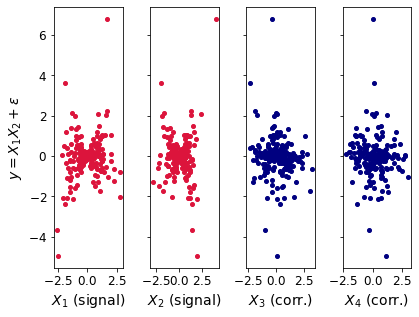

In [6]:
fig, ax = plt.subplots(ncols=4, sharey=True)
ax[0].plot(X_se3[:, 0], y_se3, 'o', markersize=4, color='crimson')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_se3[:, 1], y_se3, 'o', markersize=4, color='crimson')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 4):
    ax[i].plot(X_se3[:, i], y_se3, 'o', markersize=4, color='navy')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.subplots_adjust(wspace=0.4)
plt.show()

## Applying our method

In [7]:
import optuna
import torch.nn as nn
import torch.optim as optim
from optuna.samplers import TPESampler
from optuna.integration.pytorch_ignite import PyTorchIgnitePruningHandler
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Loss, RootMeanSquaredError
from ignite.handlers import EarlyStopping, LRScheduler, BasicTimeProfiler
from pyselect.networks import RandomFourierFeaturesNet
from pyselect.synthesizer import train_val_test_split

Define custom loss function

In [8]:
def ridge_loss(y_pred, y_true, model, reg_param):
    weights = model.rff_net[2].weight.squeeze()
    loss = torch.mean(torch.square(y_pred-y_true)) + reg_param * weights.dot(weights)
    return loss

Score function for early stopping

In [9]:
def score_function(engine):
    val_loss = engine.state.metrics['loss']
    return -val_loss

Optuna callback to save best model

In [10]:
def best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        study.set_user_attr(key='best_model', value=trial.user_attrs['best_model'])

### SE3

In [11]:
n_features = 10

In [12]:
train_size = 200
val_size = 100
test_size = 100

In [13]:
manual_seed(0)

In [14]:
X_se3, y_se3 = jordan_se3(n_samples=400)

In [15]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(X_se3, y_se3, train_size, val_size, test_size)

Generate datasets

In [16]:
train = torch.utils.data.TensorDataset(X_train, y_train)
test = torch.utils.data.TensorDataset(X_test, y_test)
val = torch.utils.data.TensorDataset(X_val, y_val)

Prepare dataloaders

In [17]:
train_loader = DataLoader(train, batch_size=train_size)
test_loader = DataLoader(test, batch_size=test_size)
val_loader = DataLoader(val, batch_size=val_size)

Objective for optuna

In [18]:
def objective(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    out_features = 50
    model = RandomFourierFeaturesNet(n_features, out_features, torch.randn) 
    model.to(device) 

    lr = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    
    reg_param = trial.suggest_float("reg_param", 1e-7, 1e-2, log=True)
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, model, reg_param)
    
    trainer = create_supervised_trainer(model, optimizer, loss_fn, device)
    
    # Add learning rate scheduler
    step_size = len(train_loader)*n_epochs//2
    torch_scheduler = StepLR(optimizer, step_size=step_size, gamma=0.5)
    scheduler = LRScheduler(torch_scheduler)
    trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
        
    # Add evaluators
    val_metric = {"loss": Loss(loss_fn)}    
    train_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)                                                
    val_evaluator = create_supervised_evaluator(model, metrics=val_metric, device=device)
    
    # Add pruner
    pruner = PyTorchIgnitePruningHandler(trial, 'loss', trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, pruner)

    # Loggers
    log_every = 300
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_training_results(engine):
        train_evaluator.run(train_loader)
        loss = train_evaluator.state.metrics['loss']
        print(f"Training - Epoch: {engine.state.epoch} Loss: {loss:.5f}")
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_validation_results(engine):
        val_evaluator.run(val_loader)
        loss = val_evaluator.state.metrics['loss']
        print(f"Validation - Epoch: {engine.state.epoch} Loss: {loss:.5f}")    
        
    @trainer.on(Events.EPOCH_COMPLETED(every=log_every))
    def log_lr():
        print(f"Learning rate: {optimizer.param_groups[0]['lr']:.4f}")
        
    # Attach basic time profiler
    time_profiler = BasicTimeProfiler()
    time_profiler.attach(trainer)
    
    # Add early stopping 
    handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    val_evaluator.add_event_handler(Events.COMPLETED, handler) 
    
    # Train the model
    trainer.run(train_loader, max_epochs=n_epochs)
    
    # Save best model in study parameters
    trial.set_user_attr(key='best_model', value=model)    
    
    # Time evaluation
    profiling_results = time_profiler.get_results()
    trial.set_user_attr(key='time_profiling', value=profiling_results)
    
    # Final evaluation
    val_evaluator.run(val_loader)
    val_loss = val_evaluator.state.metrics['loss']
    
    return val_loss

Initalize optuna study

In [19]:
tpe_sampler = TPESampler(seed=0)

In [20]:
study = optuna.create_study(direction='minimize', sampler=tpe_sampler)

[I 2022-02-18 18:14:52,911] A new study created in memory with name: no-name-b18d976c-201c-4cf1-be83-58f94fe4ac35


Run study

In [21]:
n_epochs = 1050

In [22]:
study.optimize(objective, n_trials=40, callbacks=[best_model_callback])

Training - Epoch: 300 Loss: 0.97894
Validation - Epoch: 300 Loss: 0.48468
Learning rate: 0.0125
Training - Epoch: 600 Loss: 0.78869
Validation - Epoch: 600 Loss: 0.40004
Learning rate: 0.0063
Training - Epoch: 900 Loss: 0.66485
Validation - Epoch: 900 Loss: 0.32130
Learning rate: 0.0063


[I 2022-02-18 18:14:58,517] Trial 0 finished with value: 0.287684326171875 and parameters: {'learning_rate': 0.012520653814999465, 'reg_param': 0.0003766576841599299}. Best is trial 0 with value: 0.287684326171875.


Training - Epoch: 300 Loss: 1.07680
Validation - Epoch: 300 Loss: 0.51274
Learning rate: 0.0161
Training - Epoch: 600 Loss: 0.97460
Validation - Epoch: 600 Loss: 0.50627
Learning rate: 0.0080
Training - Epoch: 900 Loss: 0.94114
Validation - Epoch: 900 Loss: 0.51641
Learning rate: 0.0080


[I 2022-02-18 18:15:01,363] Trial 1 finished with value: 0.5188458633422851 and parameters: {'learning_rate': 0.01605191133358762, 'reg_param': 5.301709347576825e-05}. Best is trial 0 with value: 0.287684326171875.


Training - Epoch: 300 Loss: 1.08675
Validation - Epoch: 300 Loss: 0.50866
Learning rate: 0.0070
Training - Epoch: 600 Loss: 1.05793
Validation - Epoch: 600 Loss: 0.49956
Learning rate: 0.0035
Training - Epoch: 900 Loss: 1.01476
Validation - Epoch: 900 Loss: 0.48565
Learning rate: 0.0035


[I 2022-02-18 18:15:04,314] Trial 2 finished with value: 0.4780842208862305 and parameters: {'learning_rate': 0.00703573702872215, 'reg_param': 0.00016961746387290997}. Best is trial 0 with value: 0.287684326171875.


Training - Epoch: 300 Loss: 1.06796
Validation - Epoch: 300 Loss: 0.50282
Learning rate: 0.0075
Training - Epoch: 600 Loss: 1.02411
Validation - Epoch: 600 Loss: 0.49522
Learning rate: 0.0038
Training - Epoch: 900 Loss: 1.00002
Validation - Epoch: 900 Loss: 0.49457
Learning rate: 0.0038


[I 2022-02-18 18:15:07,167] Trial 3 finished with value: 0.49277645111083984 and parameters: {'learning_rate': 0.007501954443620123, 'reg_param': 0.0028765041432547}. Best is trial 0 with value: 0.287684326171875.


Training - Epoch: 300 Loss: 0.28799
Validation - Epoch: 300 Loss: 0.08134
Learning rate: 0.0846
Training - Epoch: 600 Loss: 0.09880
Validation - Epoch: 600 Loss: 0.03584
Learning rate: 0.0423
Training - Epoch: 900 Loss: 0.07493
Validation - Epoch: 900 Loss: 0.03309
Learning rate: 0.0423


[I 2022-02-18 18:15:09,689] Trial 4 finished with value: 0.032061710357666015 and parameters: {'learning_rate': 0.08459126528049378, 'reg_param': 8.264328927007728e-06}. Best is trial 4 with value: 0.032061710357666015.


Training - Epoch: 300 Loss: 0.59417
Validation - Epoch: 300 Loss: 0.31822
Learning rate: 0.0383
Training - Epoch: 600 Loss: 0.38264
Validation - Epoch: 600 Loss: 0.21375
Learning rate: 0.0192
Training - Epoch: 900 Loss: 0.31672
Validation - Epoch: 900 Loss: 0.16862
Learning rate: 0.0192


[I 2022-02-18 18:15:12,373] Trial 5 finished with value: 0.1497802257537842 and parameters: {'learning_rate': 0.03832216850492789, 'reg_param': 4.4103656679709824e-05}. Best is trial 4 with value: 0.032061710357666015.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:13,208] Trial 6 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.07645


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:13,999] Trial 7 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.09221


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:14,710] Trial 8 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.09391
Training - Epoch: 300 Loss: 0.52404
Validation - Epoch: 300 Loss: 0.24287
Learning rate: 0.0360
Training - Epoch: 600 Loss: 0.22035
Validation - Epoch: 600 Loss: 0.08230
Learning rate: 0.0180
Training - Epoch: 900 Loss: 0.17354
Validation - Epoch: 900 Loss: 0.07174
Learning rate: 0.0180


[I 2022-02-18 18:15:17,237] Trial 9 finished with value: 0.07059804439544677 and parameters: {'learning_rate': 0.0360009119291161, 'reg_param': 0.0022390342721683716}. Best is trial 4 with value: 0.032061710357666015.


Training - Epoch: 300 Loss: 0.23330
Validation - Epoch: 300 Loss: 0.10592
Learning rate: 0.0857
Training - Epoch: 600 Loss: 0.10080
Validation - Epoch: 600 Loss: 0.06144
Learning rate: 0.0428
Training - Epoch: 900 Loss: 0.07882
Validation - Epoch: 900 Loss: 0.05684
Learning rate: 0.0428


[I 2022-02-18 18:15:19,826] Trial 10 finished with value: 0.05526809692382813 and parameters: {'learning_rate': 0.08568943001593249, 'reg_param': 1.8580608579177215e-06}. Best is trial 4 with value: 0.032061710357666015.


Training - Epoch: 300 Loss: 0.17126
Validation - Epoch: 300 Loss: 0.05782
Learning rate: 0.0805
Training - Epoch: 600 Loss: 0.06586
Validation - Epoch: 600 Loss: 0.02407
Learning rate: 0.0402
Training - Epoch: 900 Loss: 0.04925
Validation - Epoch: 900 Loss: 0.02210
Learning rate: 0.0402


[I 2022-02-18 18:15:22,394] Trial 11 finished with value: 0.021694512367248536 and parameters: {'learning_rate': 0.08045564515992583, 'reg_param': 1.5966637752164484e-06}. Best is trial 11 with value: 0.021694512367248536.


Training - Epoch: 300 Loss: 0.29770
Validation - Epoch: 300 Loss: 0.15838
Learning rate: 0.0918
Training - Epoch: 600 Loss: 0.16747
Validation - Epoch: 600 Loss: 0.10045
Learning rate: 0.0459
Training - Epoch: 900 Loss: 0.13383
Validation - Epoch: 900 Loss: 0.08568
Learning rate: 0.0459


[I 2022-02-18 18:15:24,937] Trial 12 finished with value: 0.07835777282714844 and parameters: {'learning_rate': 0.0918305045480768, 'reg_param': 3.5809019232756992e-06}. Best is trial 11 with value: 0.021694512367248536.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:25,662] Trial 13 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.65473


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:26,438] Trial 14 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.08636


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:27,291] Trial 15 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.58753


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:28,055] Trial 16 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.00908
Training - Epoch: 300 Loss: 0.28362
Validation - Epoch: 300 Loss: 0.09241
Learning rate: 0.0650
Training - Epoch: 600 Loss: 0.12988
Validation - Epoch: 600 Loss: 0.04206
Learning rate: 0.0325
Training - Epoch: 900 Loss: 0.09999
Validation - Epoch: 900 Loss: 0.03418
Learning rate: 0.0325


[I 2022-02-18 18:15:30,774] Trial 17 finished with value: 0.03176864147186279 and parameters: {'learning_rate': 0.06497006631702776, 'reg_param': 6.318167807242606e-07}. Best is trial 11 with value: 0.021694512367248536.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:31,542] Trial 18 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.00673


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:32,302] Trial 19 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.08227
Training - Epoch: 300 Loss: 0.37450
Validation - Epoch: 300 Loss: 0.14634
Learning rate: 0.0582
Training - Epoch: 600 Loss: 0.14554
Validation - Epoch: 600 Loss: 0.05213
Learning rate: 0.0291
Training - Epoch: 900 Loss: 0.10842
Validation - Epoch: 900 Loss: 0.04212
Learning rate: 0.0291


[I 2022-02-18 18:15:35,190] Trial 20 finished with value: 0.0394928503036499 and parameters: {'learning_rate': 0.05821123392171708, 'reg_param': 1.1335067238683373e-07}. Best is trial 11 with value: 0.021694512367248536.


Training - Epoch: 300 Loss: 0.14598
Validation - Epoch: 300 Loss: 0.05404
Learning rate: 0.0957
Training - Epoch: 600 Loss: 0.06773
Validation - Epoch: 600 Loss: 0.04275
Learning rate: 0.0478
Training - Epoch: 900 Loss: 0.05432
Validation - Epoch: 900 Loss: 0.04084
Learning rate: 0.0478


[I 2022-02-18 18:15:37,814] Trial 21 finished with value: 0.04002507209777832 and parameters: {'learning_rate': 0.09568948588216722, 'reg_param': 1.2638494070652144e-05}. Best is trial 11 with value: 0.021694512367248536.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:38,601] Trial 22 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.57643


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:39,302] Trial 23 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.90846


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:39,980] Trial 24 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.73373


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:40,774] Trial 25 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.90017


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:41,530] Trial 26 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.41786


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:42,221] Trial 27 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.53777


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:42,972] Trial 28 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.83472


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:43,873] Trial 29 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.02467
Training - Epoch: 300 Loss: 0.26935
Validation - Epoch: 300 Loss: 0.11398
Learning rate: 0.0991
Training - Epoch: 600 Loss: 0.13652
Validation - Epoch: 600 Loss: 0.05714
Learning rate: 0.0496
Training - Epoch: 900 Loss: 0.10699
Validation - Epoch: 900 Loss: 0.04733
Learning rate: 0.0496


[I 2022-02-18 18:15:46,338] Trial 30 finished with value: 0.04429356098175049 and parameters: {'learning_rate': 0.09910238037801514, 'reg_param': 2.5289199038678627e-07}. Best is trial 11 with value: 0.021694512367248536.


Training - Epoch: 300 Loss: 0.40650
Validation - Epoch: 300 Loss: 0.12652
Learning rate: 0.0566
Training - Epoch: 600 Loss: 0.18455
Validation - Epoch: 600 Loss: 0.05727
Learning rate: 0.0283
Training - Epoch: 900 Loss: 0.14320
Validation - Epoch: 900 Loss: 0.04914
Learning rate: 0.0283


[I 2022-02-18 18:15:48,950] Trial 31 finished with value: 0.04653762817382812 and parameters: {'learning_rate': 0.05664699592053336, 'reg_param': 1.7211626023567558e-07}. Best is trial 11 with value: 0.021694512367248536.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:49,608] Trial 32 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.53260


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:50,271] Trial 33 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.53525


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:50,971] Trial 34 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.08756


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:51,672] Trial 35 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.95788


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:52,295] Trial 36 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.49677


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:52,985] Trial 37 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 0.52837


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:53,730] Trial 38 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.09156


Engine run is terminating due to exception: Trial was pruned at 300 epoch.
Engine run is terminating due to exception: Trial was pruned at 300 epoch.
[I 2022-02-18 18:15:54,411] Trial 39 pruned. Trial was pruned at 300 epoch.


Training - Epoch: 300 Loss: 1.03564


Get best model

In [23]:
best_model = study.user_attrs['best_model']

In [24]:
torch.save(best_model.state_dict(), '../models/jordan-se3.pth')

Replicate best_model on different datasets

In [25]:
def replicate(trial):
    # Set optimization seed
    seed = trial.number
    manual_seed(seed)
    trial.set_user_attr('random_seed', value=seed)    
    
    X_test, y_test = jordan_se3(n_samples=test_size)
    test = torch.utils.data.TensorDataset(X_test, y_test)
    test_loader = DataLoader(test, batch_size=test_size)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    trial.set_user_attr('device', value=device)
    
    reg_param = study.best_params['reg_param']
    loss_fn = lambda y_pred, y_true: ridge_loss(y_pred, y_true, best_model, reg_param)
    
    best_model.to(device) 
        
    # Add evaluators
    test_metric = {'rmse': RootMeanSquaredError()}    
    test_evaluator = create_supervised_evaluator(best_model, metrics=test_metric, device=device)
    
    # Final evaluation
    test_evaluator.run(test_loader)
    test_rmse = test_evaluator.state.metrics['rmse']
    
    return test_rmse

In [26]:
replication = optuna.create_study(direction='minimize')

[I 2022-02-18 18:15:54,479] A new study created in memory with name: no-name-3b7f34e0-2a28-4c07-9c91-380e6f579ad2


In [27]:
replication.optimize(replicate, n_trials=30)

[I 2022-02-18 18:15:54,489] Trial 0 finished with value: 0.2640571277681379 and parameters: {}. Best is trial 0 with value: 0.2640571277681379.
[I 2022-02-18 18:15:54,492] Trial 1 finished with value: 0.32943704502086596 and parameters: {}. Best is trial 0 with value: 0.2640571277681379.
[I 2022-02-18 18:15:54,496] Trial 2 finished with value: 0.2410237365050129 and parameters: {}. Best is trial 2 with value: 0.2410237365050129.
[I 2022-02-18 18:15:54,500] Trial 3 finished with value: 0.2202409668714346 and parameters: {}. Best is trial 3 with value: 0.2202409668714346.
[I 2022-02-18 18:15:54,504] Trial 4 finished with value: 0.22636945195089883 and parameters: {}. Best is trial 3 with value: 0.2202409668714346.
[I 2022-02-18 18:15:54,508] Trial 5 finished with value: 0.1844626073084343 and parameters: {}. Best is trial 5 with value: 0.1844626073084343.
[I 2022-02-18 18:15:54,511] Trial 6 finished with value: 0.38735757486862893 and parameters: {}. Best is trial 5 with value: 0.1844626

In [28]:
replication.trials_dataframe()['value'].mean()

0.31259358455337755

In [29]:
replication.trials_dataframe()['value'].std()

0.12402816044177274

#### Visualizing

##### Bands

In [30]:
bands = best_model.rff_net[0].bandwidths.detach().to('cpu').numpy()
indexes = np.arange(1, n_features+1)

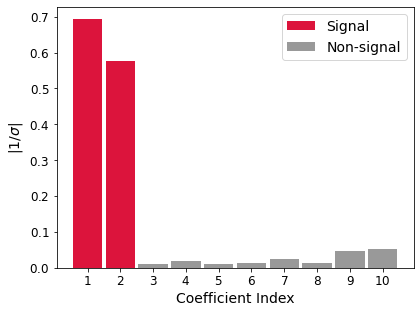

In [31]:
plt.bar(indexes[0:2], np.abs(bands)[0:2], width=0.9, color='crimson', label='Signal')
plt.bar(indexes[2:], np.abs(bands)[2:], width=0.9, color='black', alpha=0.4, label='Non-signal')
ax = plt.gca()
ax.ticklabel_format(axis="x", style="plain")
ax.set_xlabel("Coefficient Index")
ax.set_ylabel(r"$| 1/\sigma |$")
ax.set_xticks(indexes)
plt.legend()
plt.show()

##### Predictions on test

In [32]:
best_model.to('cpu')

RandomFourierFeaturesNet(
  (rff_net): Sequential(
    (0): HadamardLayer(in_features=10)
    (1): RandomFourierFeaturesLayer(in_features=10, out_features=50)
    (2): Linear(in_features=50, out_features=1, bias=True)
  )
)

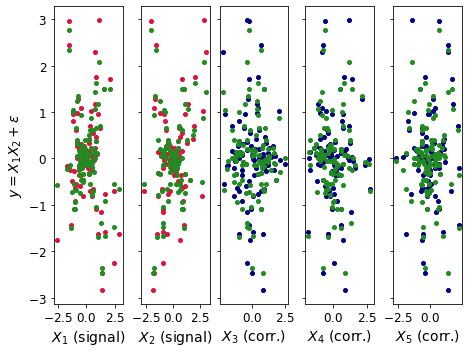

In [33]:
fig, ax = plt.subplots(ncols=5, sharey=True, constrained_layout=True)
ax[0].plot(X_test[:, 0], y_test, 'o', markersize=4, color='crimson')
ax[0].plot(X_test[:, 0], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[0].set_xlabel(r"$X_1$ (signal)")
ax[0].set_ylabel(r"$y = X_1  X_2 + \epsilon$")
ax[1].plot(X_test[:, 1], y_test, 'o', markersize=4, color='crimson')
ax[1].plot(X_test[:, 1], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
ax[1].set_xlabel("$X_2$ (signal)")
for i in range(2, 5):
    ax[i].plot(X_test[:, i], y_test, 'o', markersize=4, color='navy')
    ax[i].plot(X_test[:, i], best_model(X_test).to('cpu').detach().numpy(), 'o', markersize=4, color='forestgreen')
    ax[i].set_xlabel(f"$X_{i+1}$ (corr.)")
plt.show()

In [34]:
sorted_y_test = y_test.squeeze().sort(dim=0)[0].numpy()

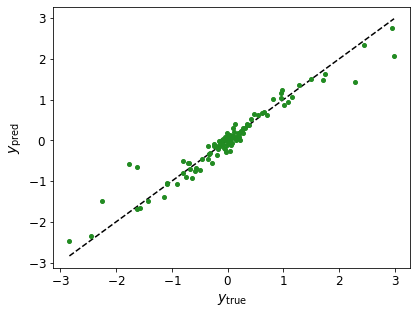

In [35]:
plt.plot(y_test, best_model(X_test).detach().squeeze().numpy(), 'o', markersize=4, color='forestgreen')
plt.plot(sorted_y_test, sorted_y_test, color='k', linestyle='dashed', zorder=-10)
plt.xlabel(r"$y_{\mathrm{true}}$")
plt.ylabel(r"$y_{\mathrm{pred}}$")
plt.show()